## Plot WROMY  with Rotation / Tilt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import nan
from pathlib import Path
from obspy import UTCDateTime

from andbro__get_timeaxis import __get_timeaxis

### Configurations

In [2]:
config = {}

config['channel'] = None

config['tend'] = UTCDateTime.now() - 300
config['tbeg'] = config['tend'] - 4*86400

config['pathToData'] = f'/import/freenas-ffb-01-data/romy_archive/'

config['resample'] = 20

config['colors'] = {  'WS1':'darkgreen', 
                      'WS4':'purple', 
                      'WS5':'darkred',
                      'WS6':'darkblue',
                      'WS7':'darkorange',
                      'WS8':'darkcyan',
                      'WS9':'cyan',
                     }

### Methods

In [3]:
def __reply(msg):
    print(f"   -> {msg}")

In [4]:
def __read_wromy_data(config):
    '''
    reads data from T1 to T2
    '''

    from pandas import date_range
    from tqdm.notebook import tqdm_notebook

    df = pd.DataFrame()
    
    for n, date in enumerate(tqdm_notebook(date_range(config['tbeg'].date, config['tend'].date))):    
        doy = str(date.timetuple().tm_yday).rjust(3,"0")
        
        path = f"{config['pathToData']}{date.year}/BW/WROMY/{config['channel']}.D/"

        if not Path(path).exists():
            __reply(f"Path: {path}, does not exists!")
            return

    
        fileName = f"BW.WROMY.{config['channel']}.D.{date.year}.{doy}"

#         print(f'   reading {fileName} ...')

        try:
            df0 = pd.read_csv(path+fileName)
            
            ## replace error indicating values (-9999, 999.9) with NaN values
            df0.replace(to_replace=-9999, value=nan, inplace=True)
            df0.replace(to_replace=999.9, value=nan, inplace=True)
              
#             ## change time from in to 6 character string
            df0.iloc[:,2] = [str(ttt).rjust(6,"0") for ttt in df0.iloc[:,2]]
          
            if n == 1:
                df = df0
            else: 
                df = pd.concat([df,df0])
        except:
            __reply(f"File: {fileName}, does not exists!")
       
    
    df.reset_index(inplace=True, drop=True)

    ## add columns with total seconds
    if 'Seconds' in df.columns:
        totalSeconds = df.Seconds + (df.Date - df.Date.iloc[0]) * 86400
        df['totalSeconds'] = totalSeconds
    

    __reply("Done \n")
    
    return df 

In [5]:
def __indicate_gaps_with_nan(df, config):
    
    differences = np.diff(df.totalSeconds, n=1)
    
    
    ## ______________
    
    sample_time_errors = [j for j in differences if j != config['resample']]

    if len(sample_time_errors) != 0:
        print(f"  -> ERROR: Found {len(sample_time_errors)} errors for the sampling time!\n")
    
    
    ## ______________
    
    gaps = [list(differences).index(k) for k in differences if k > 2*config['resample']] or []
    if gaps and gaps[0] in [0, 0.0]:
        gaps.pop(0)    
    del differences
    
    for x in gaps:
        fill_row = [i+config['resample'] if n not in [3,4,5] else np.nan for n, i in enumerate(df.iloc[x,:])]
        fill_row[0] = int(df.iloc[x,0])
        fill_row[1] = int(df.iloc[x,1])
        fill_row[2] = int(df.iloc[x,2])
        df.loc[x+0.5] = fill_row

    
    df = df.sort_index().reset_index(drop=True).convert_dtypes()

    print(f"  -> Marked {len(gaps)} gaps with NaN values!\n")
    
    return df

In [6]:
# def __get_timeaxis(dates=None, times=None, utcdatetime=None, timestamp=None, unit='seconds', unitmode='relative', dateformat="yyyymmdd"):
#     '''
#     This method returns a time axis and appropriate ticks & labels according to the set mode
    
#     ARGS: 
#         dates:       array/list of dates (e.g. 20210901)
#         times:       array/list of times (e.g. 130405)
#         utcdatetime: array/list of UTCDatt
#         timestamp:   array/list of timestamps (e.g. '20210901 13:04:05)
#         unit:        selected time unit: seconds, minutes, hours, days, time, date
#         unitmode:    relative or absolute (default: relative )
#         dateformat:  format of date passed (default: yyyymmdd)
#     RETURN: 
#         timeaxis, ticks, ticklabels, axistext
        
#     '''
    
#     from obspy import UTCDateTime
#     from numpy import array, linspace, around, unique, arange
#     from math import floor, ceil
#     from pandas import Series
    
#     ## _______________________________
#     ## 
    
#     def __time_to_seconds(arr):
#         return array([int(str(i).rjust(6, "0")[:2])*3600+int(str(i).rjust(6, "0")[2:4])*60+int(str(i).rjust(6, "0")[-2:]) for i in arr])
    
#     def __date_to_seconds(arr):
#         return array([UTCDateTime(str(i)).julday * 86400 for i in arr ])
    
#     def __timestamp_to_seconds(arr):
#         try:
#             x = UTCDateTime(str(arr[0]))
#         except:
#             print("Error: Not convertable to UTCDateTime! Aborting..."); return
        
#         dd = array([UTCDateTime(str(i)).date for i in arr])
#         tt = array([UTCDateTime(str(i)).time.strftime("%HH%MM%SS") for i in arr])
                  
#         return __date_to_seconds(dates) + __time_to_seconds(times)      

#     def __get_unique_dates(dates, times):
#         a, b = unique(dates, return_index=True)
        
#         ## trying to avoid date that starts in the mid of the day due to gap
# #         ud, udx = [], []
# #         for m, (d, i) in enumerate(zip(a,b)):
# #             if times[i] == 0:
# #                 ud.append(d)
# #                 udx.append(i)         
# #         return ud, udx
#         return a, b 

#     def __format_date(series, dateformat):
        
#         if "-" in dateformat: 
#             dateformat.replace("-","")
#             series.str.replace("-","")
        
#         if dateformat is "ddmmyy":
#             tmp = series.astype(str).str.rjust(6,"0")
#             oseries = "20"+tmp.str[-2:]+"-"+tmp.str[2:4]+"-"+tmp.str[:2]; del tmp
#             return oseries

#     def __reduce(arr):
#         if len(arr) <= 5:
#             return arr
#         else: 
#             return __reduce(arr[0:-1:2])    
    
#     ## _______________________________
#     ## run checks
                  
#     if (dates is None and times is not None) or (dates is not None and times is None):
#         print("ERROR: No valid arrays provide! Provide dates and times array!"); return
    
#     if dateformat is not "yyyymmdd":
#         dates = __format_date(Series(dates), dateformat)   
#         print(f' -> Formating: date <{dateformat}> -> <yyyymmdd>')
    
#     if dates is not None and times is not None:
#         case = 1
        
#         dates, times = array(dates), array(times)
        
#         date0_time0 = UTCDateTime(f'{dates[0]} {str(times[0]).rjust(6,"0")}')
#         date0 = date0_time0.date.strftime("%Y-%m-%d")
#         time0 = date0_time0.time.strftime("%H:%M:%S")
    
#     elif timestamp is not None: 
#         case = 2
        
#         date0, time0 = UTCDateTime(timestamp[0]).date, UTCDateTime(timestamp[0]).time

#     elif utcdatetime is not None:
#         case = 3 
        
#         date0, time0 = utcdatetime[0].date, utcdatetime[0].time
#         dates, times = [], []
        
#         for dt in utcdatetime:
#             dates.append(int(str(dt.date).replace("-","")))
#             times.append(str(dt.time).split(".")[0].replace(":",""))
        
#     if unitmode not in ['relative', 'absolute']:
#         print(f"ERROR: mode {unitmode} is not valid!")

#     units = {'seconds': ['sec', 1],
#             'minutes': ['min', 60],
#             'hours': ['hours', 3600],
#             'days': ['days', 86400],
#             'date': ['', 86400],
#             'time': ['UTC', 1],
#             }
    
#     if not unit in units.keys():
#         print(f"ERROR: unit {unit} is not valid!")
            
#     ## _______________________________
#     ## get timeaxis
        
#     ## as total seconds
#     if case == 1 or case == 3:
#         timeaxis = __date_to_seconds(dates) + __time_to_seconds(times)
#     elif case == 2:
#         timeaxis = __timestamp_to_seconds(timestamp)
    
#     ## _______________________________
#     ## get ticks & lables
#     numTicks = 5
    
#     ticks = linspace(min(timeaxis), max(timeaxis), numTicks)
#     unique_dates, unique_dates_idx = __get_unique_dates(dates, times)
    
#     ## adjust if timeaxis is relative or absolute
#     if unitmode is 'relative':
#         lticks = linspace(min(timeaxis), max(timeaxis), numTicks) - min(timeaxis)
#         text = f' Time ({units[unit][0]}) from {date0} {time0} UTC'
        
#     elif unitmode is 'absolute':
#         lticks = linspace(min(timeaxis), max(timeaxis), numTicks)
#         text = f' Time ({units[unit][0]})'
    
#     ## adjust to selected unit for timeaxis
#     if unit in ['seconds', 'minutes', 'hours']:
#         ticklabels = around(lticks/units[unit][1], decimals=0)
#         ticklabels = [int(ll) for ll in ticklabels]
        
#     elif unit in ['time']:
#         ticklabels = []
#         for t in lticks:
#             hh = str(int(t/3600-utcdatetime[0].julday*24)).rjust(2,"0") 
#             mm = str(int(t%3600/60)).rjust(2,"0")
#             ss = str(int(t%3600%60)).rjust(2,"0")
#             ticklabels.append(f'{hh}:{mm}:{ss}')
#             text = f"Time ({units[unit][0]}) on {date0}"
            
#     elif unit in ['date', 'days']:
#         ticks = [ timeaxis[idx] for idx in unique_dates_idx ]
        
#         if unit == 'date':
#             ticklabels = [ str(dd) for dd in unique_dates ]       
#             text = ""
#         elif unit == 'days':
#             ticks = ticks[1:]
#             ticklabels = arange(1, len(ticks)+1, 1)
#             text = f"Time ({units[unit][0]}) from {date0} {time0} UTC"
#     else:
#         print(f" -> Mode: {unit} is not a valid option!")       
#         return 
    
#     ## shorten list of ticklabels adaptively 
#     if len(ticks) > numTicks:
#         idx = __reduce(ticks)
#         ticklabels = [ ticklabels[n] if t in idx else '' for n, t in enumerate(ticks) ]
#     else:
#         idx = arange(0, numTicks, 1)
#         ticklabels = [ l if n in idx else '' for n, l in enumerate(ticklabels) ]

#     if unit == 'date':
#         ticklabels = [f'{s[0:4]}-{s[4:6]}-{s[6:8]}' if len(s) > 0 else s for s in ticklabels ]
        
#     return timeaxis, ticks, ticklabels, text

In [7]:
def __processing(data, config):
    
    filter_length = 10*config['resample']
    
    data.iloc[:,3:6] = data.iloc[:,3:6].rolling(filter_length).mean() 
    __reply(f"Filter: rooling mean {filter_length}!")
    
    data = data[data.index % config['resample'] == 0]
    __reply(f"Resampling: keep every {config['resample']}nth sample!")
    
    return data

In [8]:
# path_to_archive = '/bay200/gif_online/FURT/WETTER/'

# date = UTCDateTime(str("2021-11-26")).date
# filename = f'FURT.WSX.D.{str(date.day).rjust(2,"0")}{str(date.month).rjust(2,"0")}{str(date.year).rjust(2,"0")[-2:]}.0000'


# pd.read_csv(path_to_archive+filename, usecols=[0,1,10,12,13,14], names=['date', 'time', 'T', 'H', 'P','Rc'])

In [9]:
def __read_furt_data(config, show_raw=False, path_to_archive = '/bay200/gif_online/FURT/WETTER/'):
    '''
    Load a selection of data of FURT weather station for time period
    
    
    PARAMETERS:
        - config:    configuration dictionary
        - show_raw:  bool (True/False) -> shows raw data FURT head


    RETURN:
        - dataframe
        
    '''
    
    from pathlib import Path
    from obspy import UTCDateTime
    from tqdm.notebook import tqdm_notebook
    
    config['tbeg'] = UTCDateTime(config['tbeg'])
    config['tend'] = UTCDateTime(config['tend'])
    
    output_text = []
    
    
    if not Path(path_to_archive).exists():
        output_text.append(f"  -> Path: {path_to_archive}, does not exists!")
#         print(f"  -> Path: {path_to_archive}, does not exists!")
        return    
    
    
    ## list of parameters requried in configurations
    params = ['tbeg', 'tend']
    for param in params:
        if not param in config.keys():
            output_text.append(f"ERROR: {param} not in config but required!")
#             print(f"ERROR: {param} not in config but required!")
            return
    
    
    ## declare empyt dataframe
    df = pd.DataFrame()
    
    for i, date in enumerate(tqdm_notebook(np.arange(config['tbeg'].date, (config['tend']+86400).date))):
        
        date = UTCDateTime(str(date)).date
        filename = f'FURT.WSX.D.{str(date.day).rjust(2,"0")}{str(date.month).rjust(2,"0")}{str(date.year).rjust(2,"0")[-2:]}.0000'
        
#         print(f'   reading {filename} ...')

        try:
            if show_raw:
                df0 = pd.read_csv(path_to_archive+filename)            
                print(df0.columns.tolist())
                return
            else:
                df0 = pd.read_csv(path_to_archive+filename, usecols=[0,1,10,12,13,14], names=['date', 'time', 'T', 'H', 'P','Rc'])            
            
            ## substitute strings with floats
            df0['T']  = df0['T'].str.split("=", expand=True)[1].str.split("C", expand=True)[0].astype(float)
            df0['P']  = df0['P'].str.split("=", expand=True)[1].str.split("H", expand=True)[0].astype(float)
            df0['H']  = df0['H'].str.split("=", expand=True)[1].str.split("P", expand=True)[0].astype(float)
            df0['Rc'] = df0['Rc'].str.split("=", expand=True)[1].str.split("M", expand=True)[0].astype(float)
           
            
            ## replace error indicating values (-9999, 999.9) with NaN values
            df0.replace(to_replace=-9999, value=nan, inplace=True)
            df0.replace(to_replace=999.9, value=nan, inplace=True)
            
            
            if df.empty:
                df = df0
            else: 
                df = pd.concat([df, df0])
        except:
            output_text.append(f"  -> File: {filename}, does not exists!")
#             print(f"  -> File: {filename}, does not exists!")
   
    df.reset_index(inplace=True, drop=True)
        
    for text in output_text:
        print(text)
        
    return df

In [10]:
furt = __read_furt_data(config)
furt = furt[['date', 'time', 'T', 'P', 'H', 'Rc']]
furt = __processing(furt, config)

  0%|          | 0/5 [00:00<?, ?it/s]

   -> Filter: rooling mean 200!
   -> Resampling: keep every 20nth sample!


### Load WROMY Data

In [11]:
data = {}

for i in [1,4,5,6,7,8,9]:
    
    config['channel'] = 'WS'+str(i)
    
    ## load data as DataFrame
    df_new = __read_wromy_data(config)
    
    ## check for gaps
#     df_new = __indicate_gaps_with_nan(df_new, config)
    
    ## processing
#     df_new = __processing(df_new, config)

    
    ## add to dictionary
    data[config.get('channel')] = df_new; del df_new
    

  0%|          | 0/5 [00:00<?, ?it/s]

   -> Done 



  0%|          | 0/5 [00:00<?, ?it/s]

   -> Done 



  0%|          | 0/5 [00:00<?, ?it/s]

   -> Done 



  0%|          | 0/5 [00:00<?, ?it/s]

   -> Done 



  0%|          | 0/5 [00:00<?, ?it/s]

   -> Done 



  0%|          | 0/5 [00:00<?, ?it/s]

   -> Done 



  0%|          | 0/5 [00:00<?, ?it/s]

   -> Done 



## WROMY & Tilt

In [12]:
from andbro__readYaml import __readYaml
from andbro__querrySeismoData import __querrySeismoData

In [13]:
def __conversion(st, config):

    def convertTemp(trace, gain):
        Tvolt = trace.data * gain
        return 10.18 - 11.59*Tvolt + 0.3335*Tvolt**2 - 0.5316*Tvolt**3

    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity
        # print( type(conversion), type(sensitivity), type(trace.data) )

    for tr in st:
        if tr.stats.channel == 'MAT':
            tr.data = convertTemp(tr, config['gainTemp'])
        elif tr.stats.channel == 'MAN':
            tr.data = convertTilt(tr, config['convPTN'], config['gainTilt'])
        elif tr.stats.channel == 'MAE':
            tr.data = convertTilt(tr, config['convPTE'], config['gainTilt'])

        elif tr.stats.channel == 'LAT':
            tr.data = convertTemp(tr, config['gainTemp'])
        elif tr.stats.channel == 'LAN':
            tr.data = convertTilt(tr, config['convBTN'], config['gainTilt'])
        elif tr.stats.channel == 'LAE':
            tr.data = convertTilt(tr, config['convBTE'], config['gainTilt'])

    print("  -> converted data")
    return st

In [14]:
## configurations
config_tilt={}

config_tilt['save'] = False

config_tilt['seed_id'] = ["BW.TROMY..MA*", "BW.DROMY..LA*"]
config_tilt['repository'] = 'george'
config_tilt['datapath'] =  None
config_tilt['name'] = 'tiltmeter'
config_tilt['set_filter'] = 'n'

config_tilt['tbeg'] = config['tbeg']
config_tilt['tend'] = config['tend']

## tiltmeter configurations
try:
    confTilt = __readYaml('/home/brotzer/Documents/ROMY/','tiltmeter.conf')
except:
    confTilt = __readYaml('./','tiltmeter.conf')



In [15]:
pt, inv0 = __querrySeismoData(    
                            seed_id=config_tilt.get("seed_id")[0],
                            starttime=config_tilt.get("tbeg"),
                            endtime=config_tilt.get("tend"),
                            repository=config_tilt.get("repository"),
                            path=config_tilt.get("datapath"),
                            restitute=False,
                            detail=None,
                            fill_value=-9999, 
                            )

pt = pt.resample(1.0)

pt.trim(starttime=config['tbeg'], endtime=config['tend'])

confPT = confTilt['PT']
pt = __conversion(pt, confPT)

pt

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-03-27T07:33:56.439999Z - 2022-03-31T07:33:55.439999Z | 1.0 Hz, 345600 samples
BW.TROMY..MAN | 2022-03-27T07:33:56.440000Z - 2022-03-31T07:33:55.440000Z | 1.0 Hz, 345600 samples
BW.TROMY..MAT | 2022-03-27T07:33:56.439999Z - 2022-03-31T07:33:55.439999Z | 1.0 Hz, 345600 samples

  -> converted data


3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-03-27T07:33:56.439999Z - 2022-03-31T07:33:55.439999Z | 1.0 Hz, 345600 samples
BW.TROMY..MAN | 2022-03-27T07:33:56.440000Z - 2022-03-31T07:33:55.440000Z | 1.0 Hz, 345600 samples
BW.TROMY..MAT | 2022-03-27T07:33:56.439999Z - 2022-03-31T07:33:55.439999Z | 1.0 Hz, 345600 samples

 -> generate time axis
  -> Formating: date <ddmmyy> -> <yyyymmdd>
 -> generate time axis
 -> generate time axis


No handles with labels found to put in legend.
No handles with labels found to put in legend.


 -> generate time axis
 -> generate time axis
 -> generate time axis
 -> generate time axis


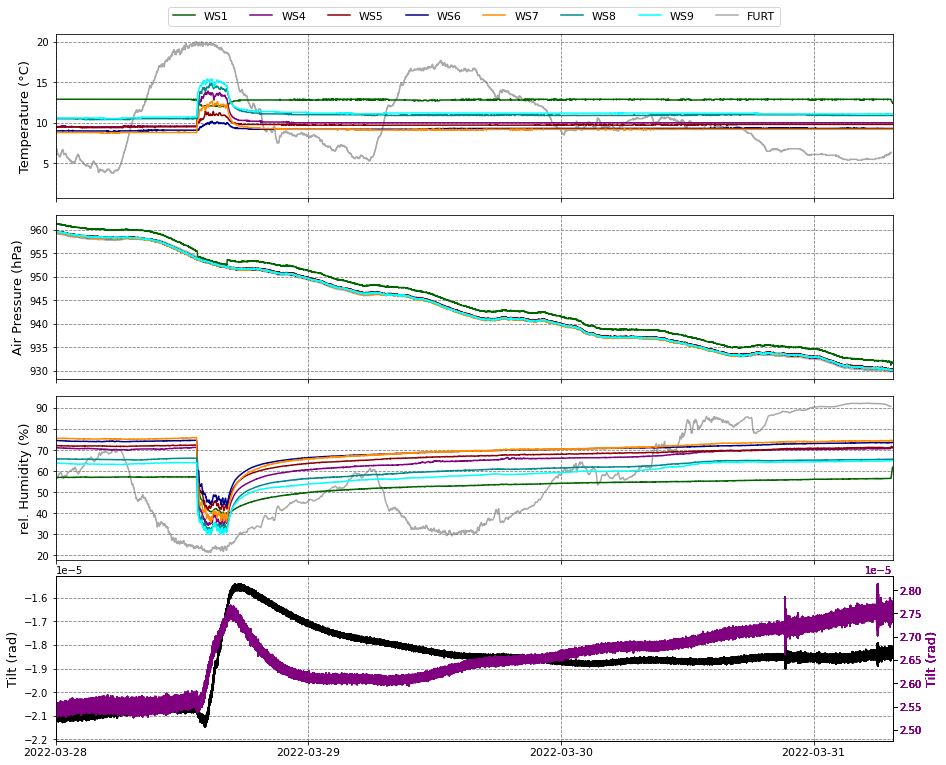

In [16]:
def __make_plot_all_stations_and_furt_and_tilt(data, furt, tilt, config, events=None):
    
    N = 4
    font = 13
    datasize = 0
    
    fig, axes = plt.subplots(N,1, figsize=[15,13], sharex=True)
    
    plt.subplots_adjust(hspace=0.1)
    
    max_val, min_val = np.zeros(N)*np.nan, np.zeros(N)*np.nan
    
    timeaxis_furt, ticks_furt, ticklabels_furt, text_furt = __get_timeaxis(
                                                                           dates=furt.iloc[:,0], 
                                                                           times=furt.iloc[:,1], 
                                                                           unit="date", 
                                                                           unitmode="absolute",
                                                                           dateformat="ddmmyy",
                                                                          )    
    timeaxis_tilt, ticks_tilt, ticklabels_tilt, text_tilt = __get_timeaxis(
                                                                           streamstats=tilt[0].stats,
                                                                           unit="date", 
                                                                           unitmode="absolute",
                                                                          )   

    NN = 0
    for station in data.keys():
        
        df = data.get(station)

        for u in range(3):
            maximum = df.iloc[:,u+3].dropna().max()
            minimum = df.iloc[:,u+3].dropna().min()
            if maximum > max_val[u] or np.isnan(max_val[u]):
                max_val[u] = maximum
            if minimum < min_val[u] or np.isnan(min_val[u]):
                min_val[u] = minimum
            
        
        if NN != len(df.iloc[:,1]): 
            timeaxis, ticks, ticklabels, text = __get_timeaxis(dates=df.iloc[:,1], 
                                                               times=df.iloc[:,2], 
                                                               unit="date", 
                                                               unitmode="absolute",
                                                               dateformat="yyyymmdd",
                                                              )

        NN = len(df.iloc[:,1])
        
        ## select ticks and ticklabels for longest data series
        if df.shape[0] > datasize:
            datasize = df.shape[0]
            xticks = ticks
            xlabels = ticklabels
            timeaxis_min, timeaxis_max = timeaxis[0], timeaxis[-1]
        

        ## plot data and adjust axes automatically
        for i in range(N):
            
            
            if i == N-1:
                axes[i].plot(timeaxis_tilt, tilt.select(channel="*E")[0].data, color='k', lw=1.5, zorder=2, label="TROMY E")
                axes2 = axes[i].twinx()
                axes2.plot(timeaxis_tilt, tilt.select(channel="*N")[0].data, color='purple', lw=1.5, zorder=2, label="TROMY N")
    
            else:
                axes[i].plot(timeaxis, df.iloc[:,i+3].rolling(60).mean(), color=config['colors'][station], lw=1.5, zorder=2, label=station)

                if station == list(data.keys())[-1]:
                    axes[i].plot(timeaxis_furt, furt.iloc[:,i+2], color='darkgrey', lw=1.5, zorder=1, label="FURT")

            axes[i].grid(ls="--",color='grey', zorder=0)
            
            if i == 0:
                axes[i].set_ylabel("Temperature (°C)",fontsize=font)
            elif i == 1:
                axes[i].set_ylabel("Air Pressure (hPa)",fontsize=font)
            elif i == 2:
                axes[i].set_ylabel("rel. Humidity (%)",fontsize=font)
                axes[i].set_xlim(timeaxis_min, timeaxis_max)
            elif i == 3:
                axes[i].set_ylabel("Tilt (rad)", fontsize=font)
                axes2.tick_params(axis='y', labelcolor='purple')
                axes2.set_ylabel("Tilt (rad)", fontsize=font, color="purple")
                
                
#             axes[N-1].set_xticklabels(xlabels[::4], fontsize=font-2)
#             axes[N-1].set_xticks(xticks[::4])
            axes[N-1].set_xticks(xticks)
            axes[N-1].set_xticklabels(xlabels, fontsize=font-2)
            axes[N-1].set_xlabel(text, fontsize=font)
            axes[N-2].legend(loc='upper center', ncol=7+1, bbox_to_anchor=(0.5, 3.4), fancybox=True, fontsize=font-2)

            
            if events:
                for event in events:
#                     axes[i].axvline(event, color='r', zorder=0, ls="-.")
                    axes[i].axvspan(event[0], event[1], color="lightgrey", alpha=0.4, zorder=1)
          
        ## adjust y-limits
#     for k in range(N):
#         axes[k].set_ylim(min_val[k]-0.005*min_val[k], max_val[k]+0.005*min_val[k])
        
    plt.show();
    return fig

__make_plot_all_stations_and_furt_and_tilt(data, furt, pt, config, events=None);

## WROMY & Rotation

In [17]:
config_rot = {}

config_rot['seed'] = "BW.ROMY.10.BJZ"

config_rot['tbeg'] = config['tbeg']
config_rot['tend'] = config['tend']-300

config_rot['repo'] = "george"

In [18]:
st00, inv = __querrySeismoData(
                            seed_id=config_rot.get("seed"),
                            starttime=config_rot.get("tbeg"),
                            endtime=config_rot.get("tend"),
                            repository=config_rot.get("repo"),
                            path=None,
                            restitute=False,
                            detail=True,
                            fill_value=-9999,
                            )


trace: BW.ROMY.10.BJZ is masked


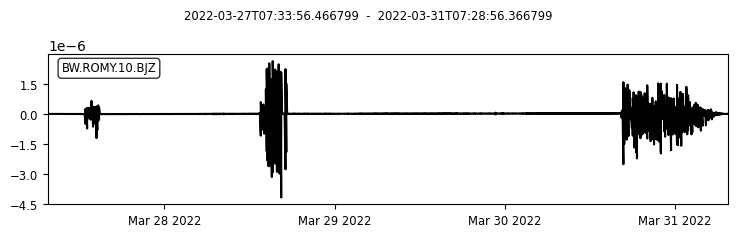

In [19]:
st = st00.copy()

st.detrend('linear')

st.remove_response(inv, output="VEL", zero_mean=True)

st.taper(0.1)

fmin, fmax = 0.01, 5.0
# st.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
st.filter('lowpass', freq=fmax, corners=8, zerophase=True)

st.resample(fmax*2)

st.plot(equal_scale=False);

 -> generate time axis
  -> Formating: date <ddmmyy> -> <yyyymmdd>
 -> generate time axis
 -> generate time axis


No handles with labels found to put in legend.
No handles with labels found to put in legend.


 -> generate time axis
 -> generate time axis
 -> generate time axis
 -> generate time axis


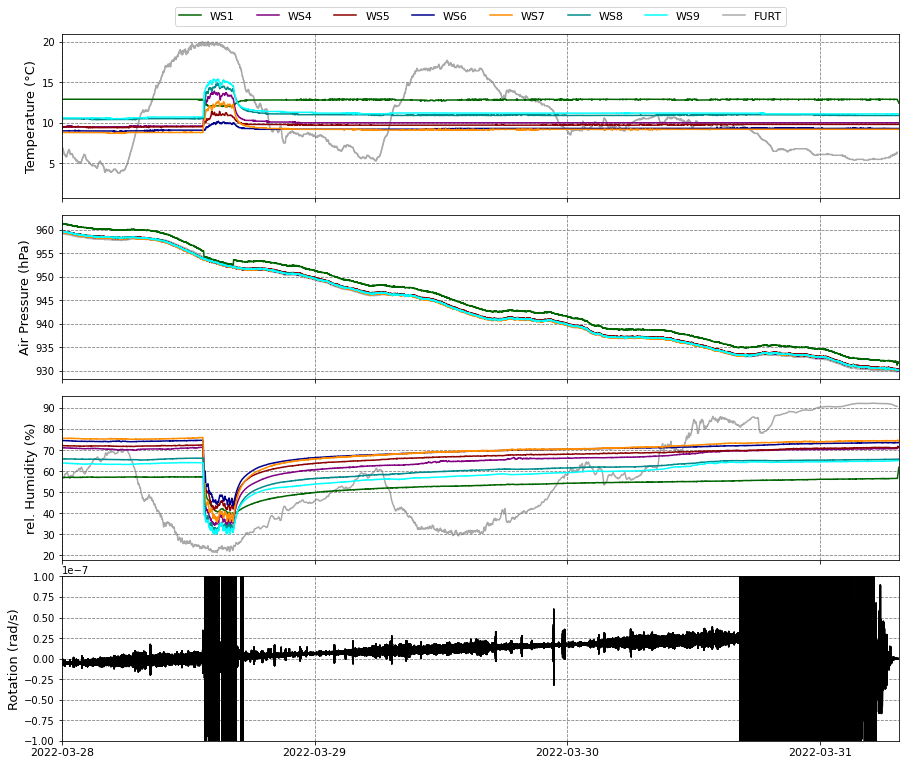

In [20]:
def __make_plot_all_stations_and_furt_and_rotation(data, furt, rota, config, events=None):
    
    N = 4
    font = 13
    datasize = 0
    
    fig, axes = plt.subplots(N,1, figsize=[15,13], sharex=True)
    
    plt.subplots_adjust(hspace=0.1)
    
    max_val, min_val = np.zeros(N)*np.nan, np.zeros(N)*np.nan
    
    timeaxis_furt, ticks_furt, ticklabels_furt, text_furt = __get_timeaxis(
                                                                           dates=furt.iloc[:,0], 
                                                                           times=furt.iloc[:,1], 
                                                                           unit="date", 
                                                                           unitmode="absolute",
                                                                           dateformat="ddmmyy",
                                                                          ) 

    timeaxis_rota, ticks_rota, ticklabels_rota, text_rota = __get_timeaxis(
                                                                           streamstats=rota[0].stats,
                                                                           unit="date", 
                                                                           unitmode="absolute",
                                                                          )   
    NN = 0
    for station in data.keys():
        
        df = data.get(station)

        for u in range(3):
            maximum = df.iloc[:,u+3].dropna().max()
            minimum = df.iloc[:,u+3].dropna().min()
            if maximum > max_val[u] or np.isnan(max_val[u]):
                max_val[u] = maximum
            if minimum < min_val[u] or np.isnan(min_val[u]):
                min_val[u] = minimum
            
        
        if NN != len(df.iloc[:,1]): 
            timeaxis, ticks, ticklabels, text = __get_timeaxis(dates=df.iloc[:,1], 
                                                               times=df.iloc[:,2], 
                                                               unit="date", 
                                                               unitmode="absolute",
                                                               dateformat="yyyymmdd",
                                                              )
            
        NN = len(df.iloc[:,1])
        
        ## select ticks and ticklabels for longest data series
        if df.shape[0] > datasize:
            datasize = df.shape[0]
            xticks = ticks
            xlabels = ticklabels
            timeaxis_min, timeaxis_max = timeaxis[0], timeaxis[-1]


        ## plot data and adjust axes automatically
        for i in range(N):
            
            if i == N-1:
                axes[i].plot(timeaxis_rota, rota.select(channel="*Z")[0].data, color='k', lw=1.5, zorder=2, label="TROMY E")
                axes[i].set_ylim(-1e-7, 1e-7)
            else:
                axes[i].plot(timeaxis, df.iloc[:,i+3].rolling(60).mean(), color=config['colors'][station], lw=1.5, zorder=2, label=station)

                if station == list(data.keys())[-1]:
                    axes[i].plot(timeaxis_furt, furt.iloc[:,i+2], color='darkgrey', lw=1.5, zorder=1, label="FURT")

            axes[i].grid(ls="--",color='grey', zorder=0)
            
            if i == 0:
                axes[i].set_ylabel("Temperature (°C)",fontsize=font)
            elif i == 1:
                axes[i].set_ylabel("Air Pressure (hPa)",fontsize=font)
            elif i == 2:
                axes[i].set_ylabel("rel. Humidity (%)",fontsize=font)
                axes[i].set_xlim(timeaxis_min, timeaxis_max)
            elif i == 3:
                axes[i].set_ylabel("Rotation (rad/s)", fontsize=font)
                
                
#             axes[N-1].set_xticklabels(xlabels[::4], fontsize=font-2)
#             axes[N-1].set_xticks(xticks[::4])
            axes[N-1].set_xticks(xticks)
            axes[N-1].set_xticklabels(xlabels, fontsize=font-2)
            axes[N-1].set_xlabel(text, fontsize=font)
            axes[N-2].legend(loc='upper center', ncol=7+1, bbox_to_anchor=(0.5, 3.4), fancybox=True, fontsize=font-2)

            
            if events:
                for event in events:
#                     axes[i].axvline(event, color='r', zorder=0, ls="-.")
                    axes[i].axvspan(event[0], event[1], color="lightgrey", alpha=0.4, zorder=1)
          
        ## adjust y-limits
#     for k in range(N):
#         axes[k].set_ylim(min_val[k]-0.005*min_val[k], max_val[k]+0.005*min_val[k])
        
    plt.show();
    return fig

__make_plot_all_stations_and_furt_and_rotation(data, furt, st, config, events=None);